In [1]:
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]='0'

In [5]:
#케라스의 이미지 제네레이터를 불러옵니다.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#제네레이터 생성
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=0.2,
                                   width_shift_range=0.05,
                                   height_shift_range=0.05,
                                   shear_range=0.05,
                                   zoom_range=0.05,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale = 1./255)

#이미지 로드
train = train_datagen.flow_from_directory('sample_data\\train',
                                        target_size = (224,224),
                                        batch_size = 16)
test = test_datagen.flow_from_directory('sample_data\\test',
                                        target_size = (224,224),
                                        batch_size = 16)

Found 1500 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [6]:
import tensorflow as tf

def res_block(node, filters, first = True, stride = 2):
    
    #Block 내의 3개의 채널의 수를 지정 해줍니다.
    filter1, filter2, filter3 = filters
    
    '''
    스테이지의 첫번째 블록에서는 이미지의 사이즈를 줄여줍니다.
    '''
    if first:
        x = tf.keras.layers.Conv2D(filter1, (1,1), strides = stride)(node)
    else:
        x = tf.keras.layers.Conv2D(filter1, (1,1))(node)
   
    '''
    활성함수와 정규화 과정을 직관적으로 확인하기 위해 Conv2D함수 밖에서
    따로 층을 구성해 줍니다.
    '''
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filter2, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filter3, (1,1))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    '''
    각 스테이지의 첫번째 잔차 블록에서는 블록 통과 후 이미지의 사이즈가
    변형되어 숏컷 연걸이 불가능 합니다. 그렇기 때문에,
    스트라이드를 통해 입력의 사이즈를 조절해 줍니다.
    '''
    if first:
        shortcut = tf.keras.layers.Conv2D(filter3, (1,1),strides = stride)(node)
        shortcut =tf.keras.layers. BatchNormalization()(shortcut)
        
        #숏컷 연결
        x = tf.keras.layers.Add()([x,shortcut])
    else:
        #숏컷 연결
        x = tf.keras.layers.Add()([x, node])
   
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [17]:
def ResNet(input_shape = (224,224,3)):

    input_tensor = tf.keras.layers.Input(shape=input_shape, dtype='float32')

    #Block 1
    block1 = tf.keras.layers.ZeroPadding2D(3)(input_tensor)
    block1 = tf.keras.layers.Conv2D(64, (7,7), strides=2)(block1)
    block1 = tf.keras.layers.BatchNormalization()(block1)
    block1 = tf.keras.layers.Activation('relu')(block1)
    
    #Block 2
    block2 = tf.keras.layers.MaxPooling2D((3,3), strides=2, padding = 'same')(block1)
    block2 = res_block(block2, [64,64,256], first=True, stride=1)
    for _ in range(2):
        block2 = res_block(block2, [64,64,256],first=False)

    #Block 3
    block3 = res_block(block2, [128,128,512], first=True)
    for _ in range(3):
        block3 = res_block(block3, [128,128,512],first=False)

    #Block 4
    block4 = res_block(block3, [256,256,1024], first=True)
    for _ in range(5):
        block4 = res_block(block4, [256,256,1024],first=False)

    #Block 5
    block5 = res_block(block4, [512,512,2048], first=True)
    for _ in range(2):
        block5 = res_block(block5, [512,512,2048],first=False)

    #FC
    flat = tf.keras.layers.GlobalAveragePooling2D()(block5)
    resnet_out = tf.keras.layers.Dense(3, activation = 'softmax')(flat)

    return tf.keras.models.Model(inputs = input_tensor, outputs = resnet_out)

In [21]:
ResNet50 = ResNet()

adam = tf.keras.optimizers.Adam(lr=1e-4)
ResNet50.compile(adam, loss = "categorical_crossentropy", metrics = ['accuracy'])

ResNet50.fit(train, epochs = 30,
             validation_data = test)

Epoch 1/30
94/94 [==============================] - 27s 285ms/step - loss: 0.9268 - accuracy: 0.5933 - val_loss: 1.8372 - val_accuracy: 0.3333
Epoch 2/30
94/94 [==============================] - 26s 274ms/step - loss: 0.5614 - accuracy: 0.7660 - val_loss: 2.8070 - val_accuracy: 0.3333
Epoch 3/30
94/94 [==============================] - 26s 279ms/step - loss: 0.4076 - accuracy: 0.8347 - val_loss: 4.0087 - val_accuracy: 0.3333
Epoch 4/30
94/94 [==============================] - 26s 273ms/step - loss: 0.3553 - accuracy: 0.8580 - val_loss: 5.3601 - val_accuracy: 0.3400
Epoch 5/30
94/94 [==============================] - 26s 274ms/step - loss: 0.3304 - accuracy: 0.8747 - val_loss: 1.1843 - val_accuracy: 0.6267
Epoch 6/30
94/94 [==============================] - 26s 279ms/step - loss: 0.3010 - accuracy: 0.8847 - val_loss: 0.6266 - val_accuracy: 0.7533
Epoch 7/30
94/94 [==============================] - 26s 276ms/step - loss: 0.2723 - accuracy: 0.8993 - val_loss: 0.4394 - val_accuracy: 0.8400

True class is low marbling


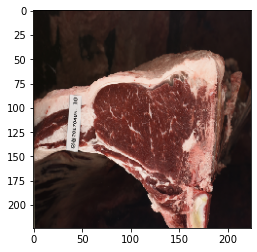

In [23]:
from matplotlib import pyplot as plt
import numpy as np

#예시 이미지 불러오기
X, y = test.next()
test_img = X[0:1]
true_y = y[0:1]

#class_dic 생성
class_dic = {v:i for i,v in test.class_indices.items()}
true_class = class_dic[np.argmax(true_y[0])]

#예시 데이터 확인
plt.imshow(test_img[0])
print('True class is {0} marbling'.format(true_class))

In [25]:
pred_y = ResNet50.predict(test_img)
pred_class = class_dic[np.argmax(pred_y[0])]
print('Pred class is {0} marbling ({1}%)'
      .format(pred_class,round(np.max(pred_y) * 100,2)))

Pred class is low marbling (99.27%)


In [42]:
from tensorflow.keras.applications import resnet

#케라스 에플리케이션에서 제공해주는 ResNet 모델
#FC 부분을 제외하고 불러온다.
ResNet_base =resnet.ResNet50(input_shape=(224,224,3),
                              include_top= False,
                              weights='imagenet')

#나머지 부분을 구현해준다.
avg_pool = tf.keras.layers.GlobalAveragePooling2D()(ResNet_base.output)
out = tf.keras.layers.Dense(3, activation = 'softmax')(avg_pool)
Keras_ResNet = tf.keras.models.Model(ResNet_base.input, out)